# Execute Quantum Dynamics with PyTDSCF -- Henon-Heiles Hamiltonian

See also https://qclovers.github.io/PyTDSCF/notebook/henon_heiles_HO-DVR.html

In [1]:
try:
    import pytdscf
except ModuleNotFoundError:
    !uv pip install -U git+https://github.com/QCLovers/PyTDSCF --quiet
try:
    import discvar
except ModuleNotFoundError:
    !uv pip install -U git+https://github.com/QCLovers/Discvar --quiet

In [2]:
import numpy as np
import sympy
from discvar import HarmonicOscillator as HO
from pytdscf import BasInfo, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian

import pympo

$$
\hat{H} = \frac{\omega}{2}\sum_{i=1}^{f} \left( - \frac{\partial^2}{\partial Q_i^2} + Q_i^2 \right) + \lambda \left( \sum_{i=1}^{f-1} Q_i^2 Q_{i+1} - \frac{1}{3} Q_{i+1}^3 \right)
$$
in mass-weighted coordinate is
$$
\hat{H} = \frac{1}{2}\sum_{i=1}^{f} \left( - \frac{\partial^2}{\partial q_i^2} + \omega^2 q_i^2 \right) + \lambda \omega^{\frac{3}{2}} \left( \sum_{i=1}^{f-1} q_i^2 q_{i+1} - \frac{1}{3} q_{i+1}^3 \right)
$$

In [3]:
ω = 3000
λ = 1.0e-07
f = 6
N = 10
m = 10
Δt = 0.1
backend = "numpy"

In [4]:
dvr_prims = [HO(N, ω) for _ in range(f)]
basinfo = BasInfo([dvr_prims])

In [5]:
ω_au = ω / units.au_in_cm1

ω_symbol = sympy.Symbol("omega")
λ_symbol = sympy.Symbol("lambda")
dq2 = [prim.get_2nd_derivative_matrix_dvr() for prim in dvr_prims]
q = [np.array(prim.get_grids()) ** 2 for prim in dvr_prims]
q2 = [np.array(prim.get_grids()) ** 2 for prim in dvr_prims]
q3 = [np.array(prim.get_grids()) ** 2 for prim in dvr_prims]

In [6]:
isite = 0
sympy.Symbol(r"\frac{\partial}{\partial q^2" + f"_{isite}" + "}")

\frac{\partial}{\partial q^2_0}

In [7]:
kinetic_sop = pympo.SumOfProducts([])
for isite in range(f):
    kinetic_sop -= (
        1
        / 2
        * pympo.OpSite(
            r"\frac{\partial}{\partial q^2" + f"_{isite}" + "}",
            isite,
            value=dq2[isite],
        )
    )
kinetic_sop.symbol

-0.5*\frac{\partial}{\partial q^2_0} - 0.5*\frac{\partial}{\partial q^2_1} - 0.5*\frac{\partial}{\partial q^2_2} - 0.5*\frac{\partial}{\partial q^2_3} - 0.5*\frac{\partial}{\partial q^2_4} - 0.5*\frac{\partial}{\partial q^2_5}

In [8]:
potential_sop = pympo.SumOfProducts([])
for isite in range(f):
    potential_sop += (
        ω_symbol**2
        / 2
        * pympo.OpSite(r"q^2" + f"_{isite}", isite, value=q2[isite])
    )
    if isite < f - 1:
        potential_sop += (
            ω_symbol**1.5
            * λ_symbol
            * pympo.OpSite(r"q^2" + f"_{isite}", isite, value=q2[isite])
            * pympo.OpSite(r"q" + f"_{isite+1}", isite + 1, value=q[isite + 1])
        )
        potential_sop -= (
            ω_symbol**1.5
            * λ_symbol
            / 3
            * pympo.OpSite(r"q^3" + f"_{isite}", isite + 1, value=q3[isite + 1])
        )
potential_sop.symbol

lambda*omega**1.5*q^2_0*q_1 + lambda*omega**1.5*q^2_1*q_2 + lambda*omega**1.5*q^2_2*q_3 + lambda*omega**1.5*q^2_3*q_4 + lambda*omega**1.5*q^2_4*q_5 - lambda*omega**1.5*q^3_0/3 - lambda*omega**1.5*q^3_1/3 - lambda*omega**1.5*q^3_2/3 - lambda*omega**1.5*q^3_3/3 - lambda*omega**1.5*q^3_4/3 + omega**2*q^2_0/2 + omega**2*q^2_1/2 + omega**2*q^2_2/2 + omega**2*q^2_3/2 + omega**2*q^2_4/2 + omega**2*q^2_5/2

2024-12-31 13:51:10.299 | INFO     | pympo.bipartite:assign:282 - assigned 1/6
2024-12-31 13:51:10.301 | INFO     | pympo.bipartite:assign:282 - assigned 2/6
2024-12-31 13:51:10.302 | INFO     | pympo.bipartite:assign:282 - assigned 3/6
2024-12-31 13:51:10.302 | INFO     | pympo.bipartite:assign:282 - assigned 4/6
2024-12-31 13:51:10.303 | INFO     | pympo.bipartite:assign:282 - assigned 5/6
2024-12-31 13:51:10.304 | INFO     | pympo.bipartite:assign:282 - assigned 6/6


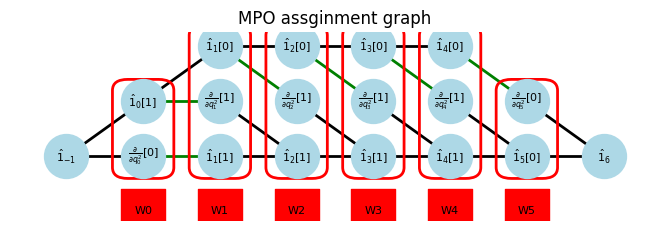

Matrix([[\frac{\partial}{\partial q^2_0}, 1]])

Matrix([
[0,                                 -0.5],
[1, -0.5*\frac{\partial}{\partial q^2_1}]])

Matrix([
[1, -0.5*\frac{\partial}{\partial q^2_2}],
[0,                                    1]])

Matrix([
[1, -0.5*\frac{\partial}{\partial q^2_3}],
[0,                                    1]])

Matrix([
[1, -0.5*\frac{\partial}{\partial q^2_4}],
[0,                                    1]])

Matrix([
[-0.5*\frac{\partial}{\partial q^2_5}],
[                                   1]])

In [9]:
am_kinetic = pympo.AssignManager(kinetic_sop.simplify())
am_kinetic.assign()
am_kinetic.show_graph()
display(*am_kinetic.Wsym)
kinetic_mpo = am_kinetic.numerical_mpo()

2024-12-31 13:51:10.528 | INFO     | pympo.bipartite:assign:282 - assigned 1/6
2024-12-31 13:51:10.532 | INFO     | pympo.bipartite:assign:282 - assigned 2/6
2024-12-31 13:51:10.654 | INFO     | pympo.bipartite:assign:282 - assigned 3/6
2024-12-31 13:51:10.763 | INFO     | pympo.bipartite:assign:282 - assigned 4/6
2024-12-31 13:51:10.926 | INFO     | pympo.bipartite:assign:282 - assigned 5/6
2024-12-31 13:51:11.194 | INFO     | pympo.bipartite:assign:282 - assigned 6/6


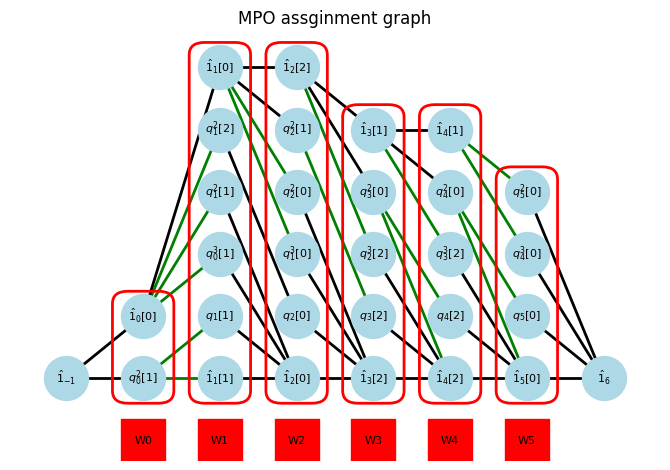

Matrix([[1, q^2_0]])

Matrix([
[1, -lambda*omega**1.5*q^3_0/3 + omega**2*q^2_1/2, lambda*omega**1.5*q^2_1],
[0,            lambda*omega**1.5*q_1 + omega**2/2,                       0]])

Matrix([
[-lambda*omega**1.5*q^3_1/3 + omega**2*q^2_2/2, q^2_2, 1],
[                                            1,     0, 0],
[                                          q_2,     0, 0]])

Matrix([
[    0, 0,                          1],
[    0, 0,      lambda*omega**1.5*q_3],
[q^2_3, 1, -lambda*omega**1.5*q^3_2/3]])

Matrix([
[    0, 0, lambda*omega**1.5*q_4 + omega**2/2],
[q^2_4, 1,         -lambda*omega**1.5*q^3_3/3],
[    0, 0,                                  1]])

Matrix([
[           lambda*omega**1.5*q_5 + omega**2/2],
[-lambda*omega**1.5*q^3_4/3 + omega**2*q^2_5/2],
[                                            1]])

In [10]:
am_potential = pympo.AssignManager(potential_sop.simplify())
am_potential.assign(keep_symbol=True)  # keep symbol is too slow but intuitive.
am_potential.show_graph()
display(*am_potential.Wsym)
potential_mpo = am_potential.numerical_mpo(subs={ω_symbol: ω_au, λ_symbol: λ})

In [11]:
display(sympy.Mul(*am_potential.Wsym)[0].expand())
display(potential_sop.symbol)
assert sympy.Mul(*am_potential.Wsym)[0].expand() == potential_sop.symbol.expand()

lambda*omega**1.5*q^2_0*q_1 + lambda*omega**1.5*q^2_1*q_2 + lambda*omega**1.5*q^2_2*q_3 + lambda*omega**1.5*q^2_3*q_4 + lambda*omega**1.5*q^2_4*q_5 - lambda*omega**1.5*q^3_0/3 - lambda*omega**1.5*q^3_1/3 - lambda*omega**1.5*q^3_2/3 - lambda*omega**1.5*q^3_3/3 - lambda*omega**1.5*q^3_4/3 + omega**2*q^2_0/2 + omega**2*q^2_1/2 + omega**2*q^2_2/2 + omega**2*q^2_3/2 + omega**2*q^2_4/2 + omega**2*q^2_5/2

lambda*omega**1.5*q^2_0*q_1 + lambda*omega**1.5*q^2_1*q_2 + lambda*omega**1.5*q^2_2*q_3 + lambda*omega**1.5*q^2_3*q_4 + lambda*omega**1.5*q^2_4*q_5 - lambda*omega**1.5*q^3_0/3 - lambda*omega**1.5*q^3_1/3 - lambda*omega**1.5*q^3_2/3 - lambda*omega**1.5*q^3_3/3 - lambda*omega**1.5*q^3_4/3 + omega**2*q^2_0/2 + omega**2*q^2_1/2 + omega**2*q^2_2/2 + omega**2*q^2_3/2 + omega**2*q^2_4/2 + omega**2*q^2_5/2

In [12]:
K = {
    tuple([(idof, idof) for idof in range(f)]): TensorOperator(mpo=kinetic_mpo)
}
kinetic = [[K]]

V = {tuple([idof for idof in range(f)]): TensorOperator(mpo=potential_mpo)}
potential = [[V]]

H = TensorHamiltonian(
    ndof=f, potential=potential, kinetic=kinetic, backend=backend
)
operators = {"hamiltonian": H}

In [13]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = m
vib_gs = [1.0] + [0.0] * (N - 1)
vib_es = [0.0] + [1.0] + [0.0] * (N - 2)
print([[vib_es] + [vib_gs] * (f - 1)])
model.init_weight_VIBSTATE = [
    [vib_es] + [vib_gs] * (f - 1)
]  # only first mode is excited

[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


In [14]:
jobname = "henon_heiles"
simulator = Simulator(jobname=jobname, model=model, backend=backend)
simulator.propagate(maxstep=100, stepsize=Δt)

2024-12-31 13:51:11,837 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-12-31 13:51:11,837 - INFO:main.pytdscf._const_cls - Log file is ./henon_heiles_prop/main.log
2024-12-31 13:51:11,837 - INFO:main.pytdscf.simulator_cls - Set integral of DVR basis
2024-12-31 13:51:11,841 - INFO:main.pytdscf.simulator_cls - Set initial wave function (DVR basis)
2024-12-31 13:51:11,841 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-12-31 13:51:11,841 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2024-12-31 13:51:11,847 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_henon_heiles.pkl
2024-12-31 13:51:11,847 - INFO:main.pytdscf.simulator_cls - Start initial step    0.000 [fs]
2024-12-31 13:51:1

(0.05467751011209484, <pytdscf.wavefunction.WFunc at 0x117838980>)

In [15]:
!ls {jobname}*

autocorr.dat     expectations.dat main.log         populations.dat


/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


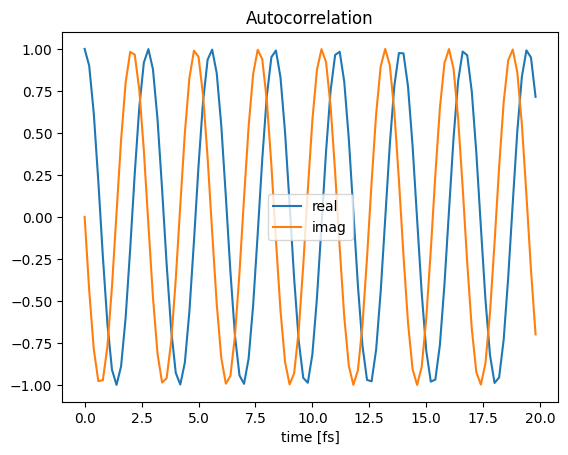

In [16]:
import matplotlib.pyplot as plt
from pytdscf import spectra

time, autocorr = spectra.load_autocorr(jobname + "_prop" + "/autocorr.dat")
plt.plot(time, autocorr.real, label="real")
plt.plot(time, autocorr.imag, label="imag")
plt.title("Autocorrelation")
plt.legend()
plt.xlabel("time [fs]")
plt.show()